## Tech stocks anomaly finder
**N.B.** If we decide to use this, it would be best to put this all in a neat class of course

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Define and get history of stocks to analyze
stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]
stocks_data = yf.Tickers(stocks)
stocks_history_df = stocks_data.history("5y", interval="1d")
stocks_history_df

[*********************100%***********************]  5 of 5 completed


Price            Close                                                   \
Ticker             AMD         ASML        GOOG        META        NVDA   
Date                                                                      
2021-01-13   91.779999   491.389069   87.066978  249.894394   13.493802   
2021-01-14   90.790001   520.630066   86.361275  243.936050   13.163232   
2021-01-15   88.209999   504.236359   86.163277  249.616364   12.823438   
2021-01-19   89.449997   525.266174   88.876404  259.288818   12.988726   
2021-01-20   88.750000   525.151428   93.642662  265.624542   13.328269   
...                ...          ...         ...         ...         ...   
2026-01-06  214.350006  1242.189941  314.549988  660.619995  187.240005   
2026-01-07  210.020004  1228.469971  322.429993  648.690002  189.110001   
2026-01-08  204.679993  1194.319946  326.010010  646.059998  185.039993   
2026-01-09  203.169998  1273.880005  329.140015  653.059998  184.860001   
2026-01-12  207.690002  1281.229980  332.730011  641.969971  184.940002   

Price      Dividends                      ... Stock Splits                 \
Ticker           AMD ASML GOOG META NVDA  ...          AMD ASML GOOG META   
Date                                      ...                               
2021-01-13       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2021-01-14       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2021-01-15       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2021-01-19       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2021-01-20       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
...              ...  ...  ...  ...  ...  ...          ...  ...  ...  ...   
2026-01-06       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2026-01-07       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2026-01-08       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2026-01-09       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   
2026-01-12       0.0  0.0  0.0  0.0  0.0  ...          0.0  0.0  0.0  0.0   

Price              Volume                                          
Ticker     NVDA       AMD     ASML      GOOG      META       NVDA  
Date                                                               
2021-01-13  0.0  60712900   513700  21882000  19528900  210028000  
2021-01-14  0.0  53408200  1450300  23590000  29739400  283120000  
2021-01-15  0.0  49340300   869200  26844000  24942900  277780000  
2021-01-19  0.0  45115100  1504000  34692000  28028500  226188000  
2021-01-20  0.0  35185800  1121900  49806000  25199900  258572000  
...         ...       ...      ...       ...       ...        ...  
2026-01-06  0.0  40033200  1895800  18989900  11074400  176862600  
2026-01-07  0.0  29715500  1351200  24681800  12846300  153543200  
2026-01-08  0.0  27505000  1682300  21789600  11921700  172457000  
2026-01-09  0.0  24147300  2393500  17893400  11621500  131072000  
2026-01-12  0.0  26400406  1472418  20315803  13287086  126383986  

[1255 rows x 35 columns]

In [3]:
stocks_history = stocks_history_df.copy()
# Hyper parameters we can fine tune
window = 30 # Rolling window size in days
# Z scores: 1 = normal, 2 >= unusual, 3 >= outlier
price_z = 2.5 # From what z-score is price change an anomaly
volume_z = 2.5 # From what z-score is trading volume an anomaly

for stock in stocks:
    
    # ================ PRICE ================
    # Calculate day by day closing price change in percentage of stock
    stocks_history['return', stock] = stocks_history['Close', stock].pct_change()
    
    # Calculate rolling mean and standard deviation per stock
    stocks_history['rolling_mean_P', stock] = stocks_history['return', stock].rolling(window).mean()
    stocks_history['rolling_std_P', stock] = stocks_history['return', stock].rolling(window).std()
    
    # Calculate z-score of rolling window
    stocks_history['rolling_z_P', stock] = (
        (stocks_history['return', stock] - stocks_history['rolling_mean_P', stock]) / stocks_history['rolling_std_P', stock]
    )

    # Anomaly trading day if z-score > 3, outlier in price change detected.
    # Based on price alone:
    # stocks_history['unusual', stock] = stocks_history['rolling_z_P', stock] > 3

    # ================ VOLUME ================
    stocks_history['rolling_mean_V', stock] = stocks_history['Volume', stock].rolling(window).mean()
    stocks_history['rolling_std_V', stock] = stocks_history['Volume', stock].rolling(window).std()

    stocks_history['rolling_z_V', stock] = (
        (stocks_history['Volume', stock] - stocks_history['rolling_mean_V', stock]) / stocks_history['rolling_std_V', stock]
    )

    # Based on volume alone
    # stocks_history['unusual', stock] = stocks_history['rolling_z_V', stock] > 3

    # Anomaly trading day if price and volume are outlier based on past 30 days.
    stocks_history['unusual', stock] = (
        (stocks_history['rolling_z_P', stock].abs() > price_z) 
        &
        (stocks_history['rolling_z_V', stock].abs() > volume_z)
    )

In [4]:
# Display dates with rolling z-score of price and volume of unusual trading days
for stock in stocks:
    print(stock)
    display(stocks_history[stocks_history["unusual", stock]][[("rolling_z_P", stock), ("rolling_z_V", stock)]])

AMD


Price,rolling_z_P,rolling_z_V
Ticker,AMD,AMD
Date,,
2021-06-17,2.889083,3.078918
2021-07-28,2.844915,4.177942
2021-11-08,3.169713,3.839174
2022-10-07,-3.179110,4.120994
2023-02-01,3.101557,4.390270
2023-05-03,-3.510569,3.032867
2023-08-02,-2.715954,4.263980
2023-11-01,3.081554,4.639959


ASML


Price,rolling_z_P,rolling_z_V
Ticker,ASML,ASML
Date,,
2021-09-17,-2.617236,3.943613
2021-09-28,-3.273277,3.984517
2022-10-04,2.763297,3.039554
2022-11-10,2.889057,2.872122
2023-07-19,-2.826450,3.632854
2024-01-24,3.371103,4.953093
2024-04-17,-2.686690,4.518704
2024-06-05,3.519290,4.358551


GOOG


Price,rolling_z_P,rolling_z_V
Ticker,GOOG,GOOG
Date,,
2021-09-10,-2.664958,3.206233
2022-01-05,-2.843506,3.088559
2022-02-02,3.352162,3.780322
2022-09-13,-2.693670,2.865626
2022-10-26,-3.730561,3.783669
2023-01-20,2.744652,3.496310
2023-02-02,2.790465,2.698699
2023-02-08,-2.669512,3.849664


META


Price,rolling_z_P,rolling_z_V
Ticker,META,META
Date,,
2021-04-29,3.191347,3.917286
2021-06-28,2.650605,3.441867
2021-07-23,2.931203,3.433874
2021-09-22,-2.734836,4.380352
2021-10-04,-2.608604,3.109499
2022-02-03,-4.847683,5.061238
2022-04-28,4.012076,3.910902
2022-09-13,-2.996719,3.120572


NVDA


Price,rolling_z_P,rolling_z_V
Ticker,NVDA,NVDA
Date,,
2021-10-26,2.560845,3.319884
2021-11-04,3.547957,4.888764
2023-02-23,2.940778,4.284631
2023-05-25,4.765348,4.628024
2024-01-08,2.952412,2.880870
2024-02-22,4.155204,2.831520
2025-01-27,-4.023785,4.803274
2025-04-09,3.514054,2.509115


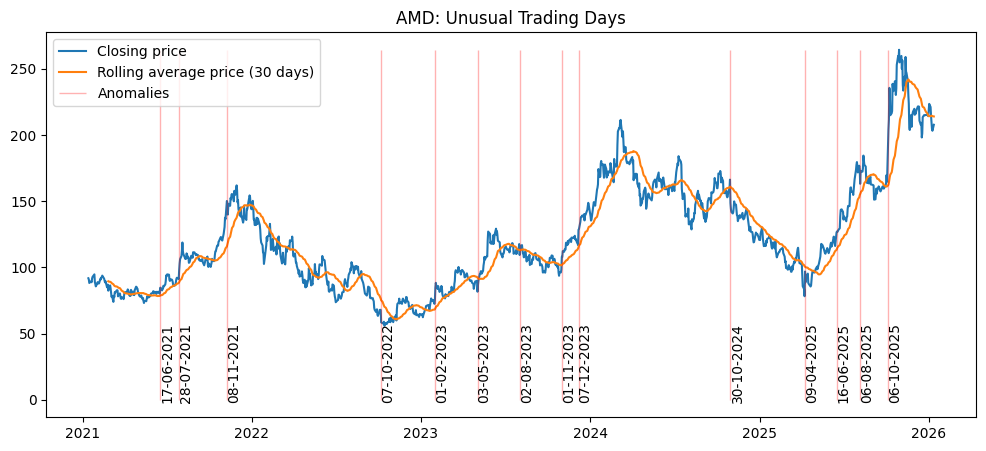

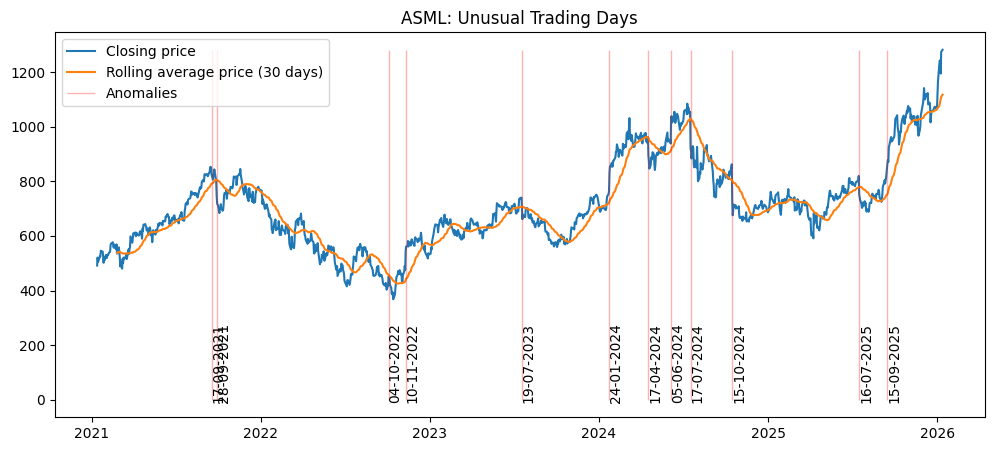

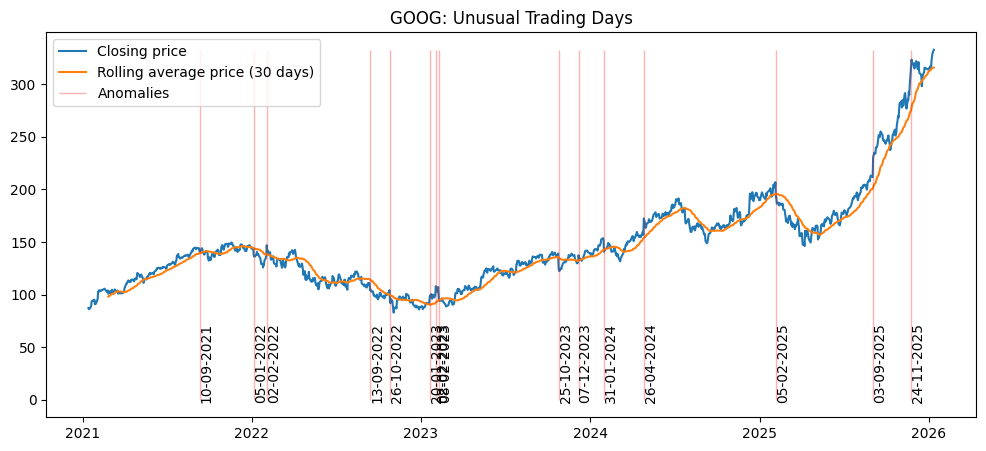

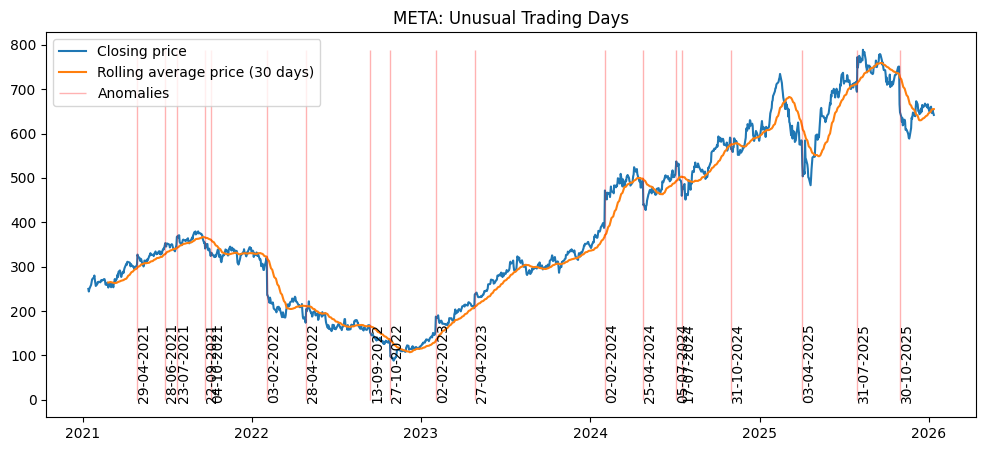

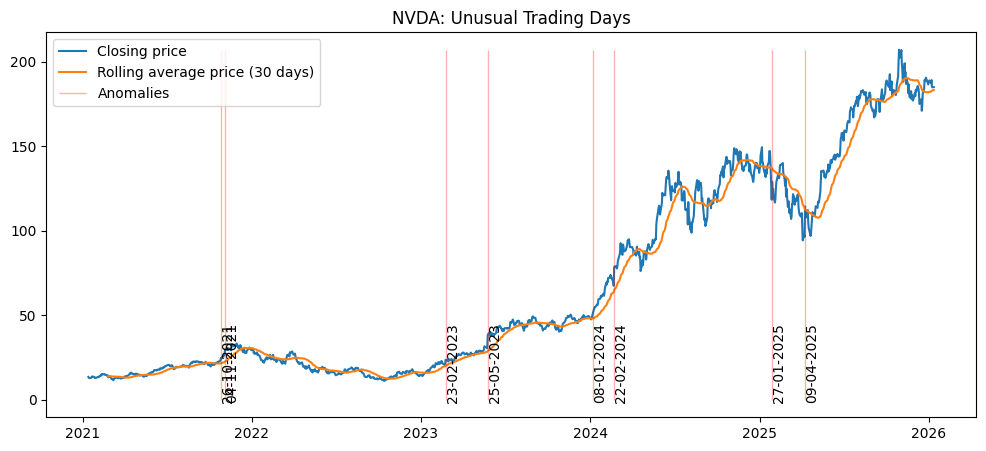

In [5]:
# Plot stock data: price, rolling average and anomalies
for stock in stocks:
    # Get index of all unusual trading days
    unusual_days = stocks_history[stocks_history["unusual", stock]].index

    # Plot closing prices
    plt.figure(figsize=(12,5))
    plt.plot(stocks_history['Close', stock], 
             label = "Closing price"
             )
    
    # Plot rolling average
    plt.plot(
        stocks_history['Close', stock].rolling(window).mean(),
        label=f"Rolling average price ({window} days)"
        )

    # Plot line at each unusual day
    plt.vlines(
            unusual_days,
            ymin=0,
            ymax=stocks_history['Close', stock].max(),
            color = 'red',
            linestyle='-', 
            alpha=0.3, 
            linewidth=1,
            label='Anomalies'
        )

    # State dates of anomalies
    for anomaly_day in unusual_days:
        plt.text(anomaly_day, 0, f"{anomaly_day.strftime('%d-%m-%Y')}", rotation = 90)

    plt.legend()
    plt.title(f"{stock}: Unusual Trading Days")
    plt.show()